In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from konlpy.tag import Okt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
from tensorflow.keras.models import load_model

In [34]:
from tqdm import tqdm

In [5]:
okt = Okt()

In [7]:
result2 = pd.read_csv('community_add_market.csv', low_memory=False)

In [8]:
# 학습을 위해 1, 0으로 긍정/ 부정을 재구분
result2['긍정점수'] = [1 if label == 1 else 0 if label == -1 else -1 for label in result2['label']]

In [9]:
result2.head(1)

,닉네임,날짜,내용,종목,내용_토큰,label,시장,명사_추출,긍정점수
0,GROK,2025-01-11T22:59:18+09:00,- 디자인 변화: S25 울트라는 기존의 각진 디자인에서 둥근 모서리로 변경되었으며...,005930,디자인 변화 울트라 기존 디자인 에서 둥글다 모서리 변경 되어다 카메라 모듈 디자인...,1,KOSPI,디자인 변화 울트라 기존 디자인 모서리 변경 카메라 모듈 디자인 변화 플러스 외관 ...,1


In [10]:
result2['긍정점수'].value_counts()

긍정점수
-1    44198
 0    15335
 1    12979
Name: count, dtype: int64

In [13]:
result2 = result2.drop_duplicates(subset=['내용_토큰'])

In [14]:
result2['긍정점수'].value_counts()

긍정점수
-1    36103
 0    14301
 1    12295
Name: count, dtype: int64

In [15]:
# 언더 샘플링

sample_data_positive = result2[result2['긍정점수'] == 1].sample(12295)
sample_data_negative = result2[result2['긍정점수'] == 0].sample(12295)

total_data = pd.concat([sample_data_positive,sample_data_negative])

In [20]:
total_data = total_data.drop_duplicates(subset=['내용'])

In [21]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24590 entries, 42986 to 17792
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   닉네임     24590 non-null  object
 1   날짜      24590 non-null  object
 2   내용      24590 non-null  object
 3   종목      24590 non-null  object
 4   내용_토큰   24590 non-null  object
 5   label   24590 non-null  int64 
 6   시장      24590 non-null  object
 7   명사_추출   23478 non-null  object
 8   긍정점수    24590 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 1.9+ MB


In [22]:
total_data['내용'].nunique()

24590

In [23]:
# 학습 데이터와, 테스트 데이터를 구분

train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=2025)

In [24]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['내용'].nunique(), train_data['긍정점수'].nunique()

(18442, 2)

In [25]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 18442


<Axes: xlabel='긍정점수'>

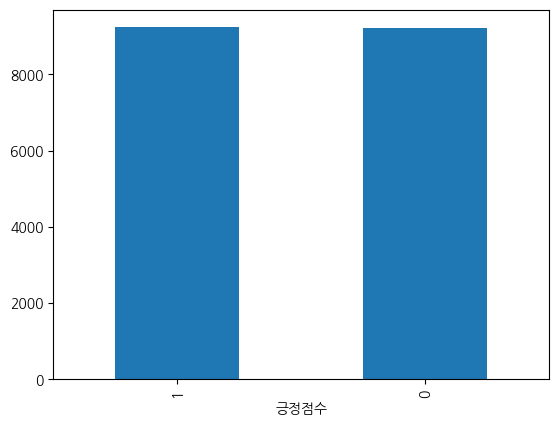

In [26]:
train_data['긍정점수'].value_counts().plot(kind = 'bar')

In [27]:
print(train_data.groupby('긍정점수').size().reset_index(name = 'count'))

   긍정점수  count
0     0   9206
1     1   9236


In [28]:
print(train_data.isnull().values.any())

True


In [29]:
print(train_data.isnull().sum())

닉네임        0
날짜         0
내용         0
종목         0
내용_토큰      0
label      0
시장         0
명사_추출    829
긍정점수       0
dtype: int64


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['내용'] = train_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,닉네임,날짜,내용,종목,내용_토큰,label,시장,명사_추출,긍정점수
59448,청사초롱맘,2024-12-26T09:52:40+09:00,연초에 팍 오르겠죠유증 포기할 수 있다면,007660,연초 오르다 유증 포기 하다 있다,-1,KOSPI,연초 오르다 유증 포기,0
19266,배롱이마찌,2024-12-20T08:53:01+09:00,내 주식도 주식이지만 나라 경제 보는 거 같아 더 안타깝다 이렇게 아무것도 안 하고...,051910,주식 주식 이지만 나라 경제 보다 같다 안타깝다 이렇게 아무 하다 놓다 있다 정부 ...,-1,KOSPI,주식 주식 나라 경제 아무 정부 내란 자기 자리 어이 국민 모두 도탄 도탄,0
56994,놀러왔다,2024-12-30T15:04:38+09:00,공매도로 떨구고 받아먹고 난리네,066970,공매도 떨구다 받다 먹다 난리,-1,KOSPI,공매도 난리,0
18137,코인나스닥,2024-12-19T18:50:23+09:00,코로나때 잠깐 빠졌다가 바로 반등 수익 구간이었음 그 전에는 다 지지해줬고 홀딩스는...,005490,코로나 잠깐 빠지다 바로 반등 수익 구간 이다 에는 지지 해주다 홀딩스 장기 추세 ...,1,KOSPI,코로나 잠깐 바로 반등 수익 구간 지지 홀딩스 장기 추세 근처 수익 선물 지금 부터 구간,1
70896,Ssangttaompyo,2024-12-17T09:56:27+09:00,얼마전부터 주식을 시작한 살 입니다 혹시 와 요놈 중에서 고민중인데 어떤거에 알바비...,360750,얼마 부터 주식 시작 이다 혹시 오다 에서 고민 인데 어떤 알바 투자 하다 괜찮다 ...,1,ETF,얼마 부터 주식 시작 혹시 고민 알바 투자 추천,1


In [31]:
train_data['내용'] = train_data['내용'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['내용'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())


닉네임        0
날짜         0
내용         0
종목         0
내용_토큰      0
label      0
시장         0
명사_추출    829
긍정점수       0
dtype: int64


C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2465209330.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['내용'].replace('', np.nan, inplace=True)


In [32]:
test_data.drop_duplicates(subset = ['내용'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['내용'] = test_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['내용'] = test_data['내용'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['내용'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 5865


C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2558759913.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['내용'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [33]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [35]:
X_train = []
for sentence in tqdm(train_data['내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)


100%|██████████| 18442/18442 [01:11<00:00, 257.11it/s]


In [36]:
print(X_train[:3])

[['연초', '팍', '오르다', '유증', '포기', '수', '있다'], ['내', '주식', '주식', '이지만', '나라', '경제', '보다', '거', '같다', '더', '안타깝다', '이렇게', '아무', '것', '안', '손', '놓다', '있다', '거', '정부', '이르다', '안', '되다', '내란', '일으키다', '자기', '자리', '지키다', '아직도', '저러다', '있다', '게', '말', '되다', '답답하다', '어이', '없다', '국민', '다', '데려가다', '저러다', '모두', '도탄', '이다', '도탄'], ['공매도', '로', '떨구다', '받다', '먹다', '난리', '네']]


In [37]:
X_test = []
for sentence in tqdm(test_data['내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


100%|██████████| 5865/5865 [00:22<00:00, 261.06it/s]


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [39]:
print(tokenizer.word_index)


{'을': 1, '있다': 2, '되다': 3, '보다': 4, '없다': 5, '로': 6, '이다': 7, '에서': 8, '만': 9, '좋다': 10, '아니다': 11, '오르다': 12, '다': 13, '원': 14, '적': 15, '년': 16, '고': 17, '주가': 18, '떨어지다': 19, '더': 20, '같다': 21, '주식': 22, '것': 23, '주': 24, '가다': 25, '오늘': 26, '투자': 27, '까지': 28, '요': 29, '오다': 30, '안': 31, '매수': 32, '일': 33, '상승': 34, '국장': 35, '때': 36, '않다': 37, '하고': 38, '수': 39, '받다': 40, '인': 41, '생각': 42, '만원': 43, '성': 44, '내': 45, '저': 46, '아': 47, '못': 48, '배당': 49, '나': 50, '시장': 51, '들다': 52, '지금': 53, '진짜': 54, '네': 55, '하': 56, '나오다': 57, '중': 58, '전': 59, '월': 60, '돈': 61, '많다': 62, '거': 63, '하락': 64, '미국': 65, '왜': 66, '수익': 67, '다시': 68, '지': 69, '인데': 70, '사람': 71, '제': 72, '그': 73, '크다': 74, 'ㅋㅋ': 75, '분': 76, '너무': 77, '면': 78, '시': 79, '믿다': 80, '알다': 81, '기업': 82, '말': 83, '그냥': 84, '매도': 85, '또': 86, '많이': 87, '대': 88, '그렇다': 89, '점': 90, '게': 91, '실적': 92, '주주': 93, '등': 94, '기': 95, '먹다': 96, '회사': 97, '이제': 98, '부터': 99, '사다': 100, '미장': 101, '삼성': 102, '올라가다': 103, '장': 104, 

In [40]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 17596
등장 빈도가 2번 이하인 희귀 단어의 수: 9933
단어 집합에서 희귀 단어의 비율: 56.450329620368265
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.712549177085818


In [41]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7664


In [42]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [43]:
print(X_train[:3])


[[2044, 2648, 12, 705, 794, 39, 2], [45, 22, 22, 706, 321, 561, 4, 63, 21, 20, 646, 222, 579, 23, 31, 297, 580, 2, 63, 581, 236, 31, 3, 1727, 3889, 936, 363, 699, 542, 2201, 2, 91, 83, 3, 1031, 1471, 5, 592, 13, 5575, 2201, 234, 7], [647, 6, 336, 40, 96, 1976, 55]]


In [44]:
y_train = np.array(train_data['긍정점수'])
y_test = np.array(test_data['긍정점수'])

In [45]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [47]:
# 빈 샘플들을 제거
X_train = np.array(X_train, dtype=object)
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


18429
18429


리뷰의 최대 길이 : 301
리뷰의 평균 길이 : 17.30452004992132


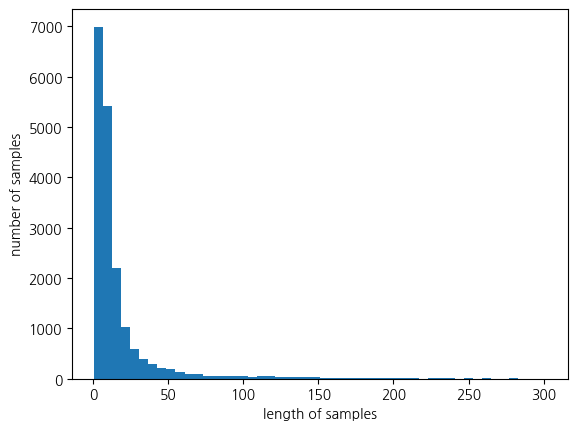

In [48]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [49]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [52]:
max_len = 70
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 70 이하인 샘플의 비율: 95.44739269629389


In [53]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [56]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.6883 - loss: 0.5839
Epoch 1: val_acc improved from -inf to 0.93435, saving model to best_model.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - acc: 0.6892 - loss: 0.5828 - val_acc: 0.9343 - val_loss: 0.1984
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.9448 - loss: 0.1745
Epoch 2: val_acc improved from 0.93435 to 0.95524, saving model to best_model.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - acc: 0.9448 - loss: 0.1745 - val_acc: 0.9552 - val_loss: 0.1301
Epoch 3/15
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.9728 - loss: 0.0869
Epoch 3: val_acc did not improve from 0.95524
231/231 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - acc: 0.9728 - loss: 0.0869 - val_acc: 0.9536 - val_loss: 0.1243
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.9838 - loss: 0.0555
Epoch 4: val_acc improved from 0.95524 to 0.95768, saving model to best_model.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - acc: 

In [58]:
loaded_model = load_model('best_model.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.9621 - loss: 0.1176

 테스트 정확도: 0.9640


In [59]:
import pickle

In [60]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [61]:
import re

In [67]:
def sentiment_predict(new_sentence):
    # 특수 문자 제거
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
    # 토큰화
    new_sentence = okt.morphs(new_sentence, stem=True)
    # 정수 인코딩
    encoded = tokenizer.texts_to_sequences([new_sentence])
    # 패딩
    pad_new = pad_sequences(encoded, maxlen=max_len)
    # 예측
    predicted_value = loaded_model.predict(pad_new)
    # 예측 결과에서 첫 번째 요소 선택
    score = predicted_value[0]  # 안전하게 scalar로 변환
    
    # 결과 출력
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


In [76]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


In [77]:
sentiment_predict('이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
99.96% 확률로 긍정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [78]:
sentiment_predict("주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
100.00% 확률로 부정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [79]:
sentiment_predict('이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
100.00% 확률로 긍정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [80]:
sentiment_predict("이번 분기 실적이 예상보다 좋아서 주가가 오를 것 같아요.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
99.99% 확률로 긍정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [81]:
sentiment_predict("주식 시장이 불안정한데, 어떤 종목을 사는 게 좋을까요?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
99.98% 확률로 긍정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [82]:
sentiment_predict("최근 뉴스에 따르면 이 회사가 새로운 제품을 출시한다고 하더군요.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
92.68% 확률로 부정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [83]:
sentiment_predict("이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요."
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
99.86% 확률로 부정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [89]:
negative_sentences = [
    "이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요.", # 부정
    "이 기업의 경영진이 믿을 수 없어서 투자하기가 망설여집니다.", # 부정
    "최근 뉴스에서 부정적인 이슈가 많아 주식이 불안정합니다.",  # 부정
    "주가가 계속 하락세인데, 더 이상 보유할 이유가 없네요.",    # 부정
    "이 회사의 제품이 소비자에게 외면받고 있어서 걱정입니다.",  # 부정
    "전문가들이 이 종목을 추천하지 않아서 매도해야 할 것 같아요.",  # 부정
    "지속적인 적자에 시달리고 있어서 회복이 힘들 것 같습니다.", # 부정  
    "주식 시장 전반이 불안정한데 이 종목은 더 위험해 보입니다.",    # 부정
    "배당금이 줄어들었고, 앞으로도 회복 가능성이 낮아 보입니다.",   # 부정
    "외국인 투자자들이 빠져나가고 있어 주가에 부정적인 영향을 미칠 것 같습니다.",   # 부정
    "이 회사는 실적이 계속 나빠지고 있어요. 이제는 매도해야 할 때인 것 같습니다.",  # 부정
    "주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다.",  # 부정
    "이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요.",   # 부정
    "이 기업의 경영진이 믿을 수 없어서 투자하기가 망설여집니다.",   # 부정
    "최근 뉴스에서 부정적인 이슈가 많아 주식이 불안정합니다.",  # 부정
    "주가가 계속 하락세인데, 더 이상 보유할 이유가 없네요.",    # 부정
    "이 회사의 제품이 소비자에게 외면받고 있어서 걱정입니다.",  # 부정
    "전문가들이 이 종목을 추천하지 않아서 매도해야 할 것 같아요.",  # 부정
    "지속적인 적자에 시달리고 있어서 회복이 힘들 것 같습니다.", # 부정
    "주식 시장 전반이 불안정한데 이 종목은 더 위험해 보입니다.",    # 부정
    "배당금이 줄어들었고, 앞으로도 회복 가능성이 낮아 보입니다.",   # 부정
    "외국인 투자자들이 빠져나가고 있어 주가에 부정적인 영향을 미칠 것 같습니다.",    # 부정
    "이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.",  # 긍정
    "이번 분기 실적이 예상보다 좋았어요. 강력한 매수 추천합니다!",  # 긍정
    "이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!",  # 긍정
    "이번 분기 실적이 기대 이상이라 주가가 상승할 것 같아요.",
    "이 회사의 기술력이 탁월해서 앞으로의 성장 가능성이 큽니다.",
    "주식이 오랜만에 반등해서 너무 기쁘네요!",
    "상장 이후 꾸준히 오르는 모습에 투자하기 잘했다는 생각이 들어요.",
    "외국인 투자자들이 많이 들어오고 있어서 긍정적인 신호입니다.",
    "배당금이 증가해서 안정적인 투자처로 보입니다.",
    "이 기업의 새로운 제품이 시장에서 좋은 반응을 얻고 있습니다.",
    "전문가들이 추천하는 종목이라 믿고 투자하고 있습니다.",
    "최근 긍정적인 뉴스가 많아 주가가 더 오를 것 같아요.",
    "이 회사의 비전이 확실해서 장기 투자로 괜찮다고 생각해요."
]

for sentence in negative_sentences:
    sentiment_predict(sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
99.86% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
92.74% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
95.86% 확률로 긍정 리뷰입니다.



C:\Users\hydrl\AppData\Local\Temp\ipykernel_14132\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
99.91% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
90.22% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
61.46% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
99.59% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
99.94% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
99.87% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
99.90% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
62.42% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
100.00% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
99.86% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
92.74% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
95.86% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
99.91% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
90.22% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
61.46% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
99.59% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
9

In [ ]:
긍정은 잘 찾는데 부정을 잘 못찾는다

부정단어에 큰 감점

In [ ]:
"이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요."
"이 기업의 경영진이 믿을 수 없어서 투자하기가 망설여집니다."
"최근 뉴스에서 부정적인 이슈가 많아 주식이 불안정합니다."
"주가가 계속 하락세인데, 더 이상 보유할 이유가 없네요."
"이 회사의 제품이 소비자에게 외면받고 있어서 걱정입니다."
"전문가들이 이 종목을 추천하지 않아서 매도해야 할 것 같아요."
"지속적인 적자에 시달리고 있어서 회복이 힘들 것 같습니다."
"주식 시장 전반이 불안정한데 이 종목은 더 위험해 보입니다."
"배당금이 줄어들었고, 앞으로도 회복 가능성이 낮아 보입니다."
"외국인 투자자들이 빠져나가고 있어 주가에 부정적인 영향을 미칠 것 같습니다."

In [22]:
# 주식 커뮤니티 샘플 문장
test_samples = [
    "이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.",  # 긍정
    "이번 분기 실적이 예상보다 좋았어요. 강력한 매수 추천합니다!",  # 긍정
    "이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!",  # 긍정
    "이 회사는 실적이 계속 나빠지고 있어요. 이제는 매도해야 할 때인 것 같습니다.",  # 부정
    "주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다."  # 부정
]

In [23]:
X_test_samples = vectorizer.transform(test_samples)

In [24]:
# 예측
y_pred = model.predict(X_test_samples)
y_pred_classes = [1 if p > 0.5 else 0 for p in y_pred]

# 결과 출력
for sample, pred in zip(test_samples, y_pred_classes):
    sentiment = "긍정" if pred == 1 else "부정"
    print(f"문장: '{sample}' -> 예측: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
문장: '이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.' -> 예측: 긍정
문장: '이번 분기 실적이 예상보다 좋았어요. 강력한 매수 추천합니다!' -> 예측: 긍정
문장: '이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!' -> 예측: 부정
문장: '이 회사는 실적이 계속 나빠지고 있어요. 이제는 매도해야 할 때인 것 같습니다.' -> 예측: 부정
문장: '주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다.' -> 예측: 긍정
